# Housing Unit Allocation Workflow

## Overview
Functions to obtain and clean data required for the version 2 Housing Unit Allocation. 
The workflow improves on the [housing unit allocation algorithm found in pyincore](https://github.com/IN-CORE/pyincore/blob/develop/pyincore/analyses/housingunitallocation/housingunitallocation.py).

### Found issues in the original HUA:
1. Over predicting housing units in a building 
2. Not assigning one housing unit per structure before assigning more housing units
3. Matching extra housing units based on tenure - if there are 2 renters in block then match the extra renter with the other renter.

### Resources and references:
For an overview of the housing unit allocation method see:

Rosenheim, N., Guidotti, R., Gardoni, P., & Peacock, W. G. (2021). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure, 6(6), 385-401.

## Required Inputs
Program requires the following inputs:
1. Housing unit inventory file from ncoda_06dv1_run_HUI_v2_workflow.ipynb
2. Building inventory file from pyincore
    - Future version of ICD will provide tools for generating a building inventory file
    - Current version will require users to have an IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory merged with a building inventory and a codebook that describes the data.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE) for the housing unit allocation model.

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_06ev1_run_HUA_workflow
- task:       Run the Housing Unit Allocation Workflow
- See github commits for description of program updates
- Current Version:    2022-06-16 - testing workflow
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [1]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage

from pyincore_viz.geoutil import GeoUtil as viz

In [2]:
import scooby # Reports Python environment

In [3]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas']))


--------------------------------------------------------------------------------
  Date: Tue Jun 21 14:19:20 2022 Eastern Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45)
  [MSC v.1929 64 bit (AMD64)]

            pandas : 1.4.2
             numpy : 1.22.3
             scipy : 1.8.0
           IPython : 8.3.0
        matplotlib : 3.5.2
            scooby : 0.5.12
--------------------------------------------------------------------------------


In [4]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [5]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.4.1


In [6]:
# create data_service object for loading files
data_service = DataService(client)

### Read in Building Inventory

In [262]:
# Building inventory
# bldg_inv_id = "62ab7dcbf328861e25ffea9e" # New building inventory
bldg_inv_id = "6036c2a9e379f22e1658d451" # Old building inventory
# load building inventory
bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
filename = bldg_inv.get_file_path('shp')
print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\6036c2a9e379f22e1658d451\lumberton_building_inventory_w_strcid\lumberton_building_inventory_w_strcid.shp


In [263]:
bldg_inv_gdf = gpd.read_file(filename)

from pyproj import CRS
bldg_inv_gdf.crs = CRS("epsg:4326")
bldg_inv_gdf.head()

,guid,strctid,ffe_elev,archetype,parid,struct_typ,no_stories,a_stories,b_stories,bsmt_type,...,dwell_unit,str_typ2,occ_typ2,appr_bldg,appr_land,appr_tot,year_built,lhsm_elev,g_elev,geometry
0,efd13166-d7a0-476b-ada5-c55cea1f0184,STefd13166-d7a0-476b-ada5-c55cea1f0184,41.41049,1,3715514603,None,1,0,0,None,...,0,None,None,0,0,0,1988,0.0,40.2336,POINT (-79.08926 34.55354)
1,66352d95-70cb-46cb-8904-576f3ee3e9d3,ST66352d95-70cb-46cb-8904-576f3ee3e9d3,43.86419,2,3715516008,None,1,0,0,None,...,0,None,None,0,0,0,1985,0.0,42.9768,POINT (-79.08488 34.56072)
2,a4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,STa4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,40.84585,2,3715514607,None,1,0,0,None,...,0,None,None,0,0,0,1988,0.0,39.9288,POINT (-79.08826 34.55475)
3,e433891c-aa7a-47b0-a6aa-1b0895a65908,STe433891c-aa7a-47b0-a6aa-1b0895a65908,40.90913,2,3715514606,None,1,0,0,None,...,0,None,None,0,0,0,1988,0.0,39.9288,POINT (-79.08842 34.55446)
4,7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,ST7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,40.69086,1,3715514605,None,1,0,0,None,...,0,None,None,0,0,0,1988,0.0,39.6240,POINT (-79.08862 34.55423)


In [264]:
bldg_inv_gdf.columns

Index(['guid', 'strctid', 'ffe_elev', 'archetype', 'parid', 'struct_typ',
       'no_stories', 'a_stories', 'b_stories', 'bsmt_type', 'sq_foot',
       'gsq_foot', 'occ_type', 'occ_detail', 'major_occ', 'broad_occ',
       'repl_cst', 'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val',
       'efacility', 'dwell_unit', 'str_typ2', 'occ_typ2', 'appr_bldg',
       'appr_land', 'appr_tot', 'year_built', 'lhsm_elev', 'g_elev',
       'geometry'],
      dtype='object')

In [265]:
bldg_inv_gdf[['guid','strctid','archetype',
    'appr_bldg','year_built','g_elev','lhsm_elev']].head()

,guid,strctid,archetype,appr_bldg,year_built,g_elev,lhsm_elev
0,efd13166-d7a0-476b-ada5-c55cea1f0184,STefd13166-d7a0-476b-ada5-c55cea1f0184,1,0,1988,40.2336,0.0
1,66352d95-70cb-46cb-8904-576f3ee3e9d3,ST66352d95-70cb-46cb-8904-576f3ee3e9d3,2,0,1985,42.9768,0.0
2,a4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,STa4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,2,0,1988,39.9288,0.0
3,e433891c-aa7a-47b0-a6aa-1b0895a65908,STe433891c-aa7a-47b0-a6aa-1b0895a65908,2,0,1988,39.9288,0.0
4,7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,ST7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,1,0,1988,39.6240,0.0


In [266]:
# Check Unique ID
bldg_inv_gdf[['guid','strctid']].astype(str).describe().T

,count,unique,top,freq
guid,20091,20091,efd13166-d7a0-476b-ada5-c55cea1f0184,1
strctid,20091,20091,STefd13166-d7a0-476b-ada5-c55cea1f0184,1


In [267]:
bldg_inv_gdf[['guid','strctid','archetype',
    'appr_bldg','year_built','g_elev','lhsm_elev']].count()

guid          20091
strctid       20091
archetype     20091
appr_bldg     20091
year_built    20091
g_elev        20091
lhsm_elev     20091
dtype: int64

## Explore Archetypes 

For list of 15 archetypes, see:

https://incore.ncsa.illinois.edu/doc/incore/notebooks/Lumberton_testbed/Lumberton_testbed.html

In [268]:
bldg_inv_gdf[['guid','strctid','archetype',
    'appr_bldg','year_built','g_elev','lhsm_elev']].groupby('archetype').count()

,guid,strctid,appr_bldg,year_built,g_elev,lhsm_elev
archetype,,,,,,
0,25,25,25,25,25,25
1,6070,6070,6070,6070,6070,6070
2,10273,10273,10273,10273,10273,10273
3,249,249,249,249,249,249
4,1391,1391,1391,1391,1391,1391
5,1060,1060,1060,1060,1060,1060
6,9,9,9,9,9,9
7,10,10,10,10,10,10
8,14,14,14,14,14,14


In [269]:
bldg_inv_gdf[['appr_bldg','year_built','g_elev','lhsm_elev']].describe().T

,count,mean,std,min,25%,50%,75%,max
appr_bldg,20091.0,0.000000,0.000000,0.00,0.0000,0.0000,0.0000,0.0000
year_built,20091.0,1973.188194,79.571552,0.00,1971.0000,1982.0000,1983.0000,1988.0000
g_elev,20091.0,41.670883,3.838544,30.48,39.3192,41.7576,44.5008,50.5968
lhsm_elev,20091.0,0.000000,0.000000,0.00,0.0000,0.0000,0.0000,0.0000


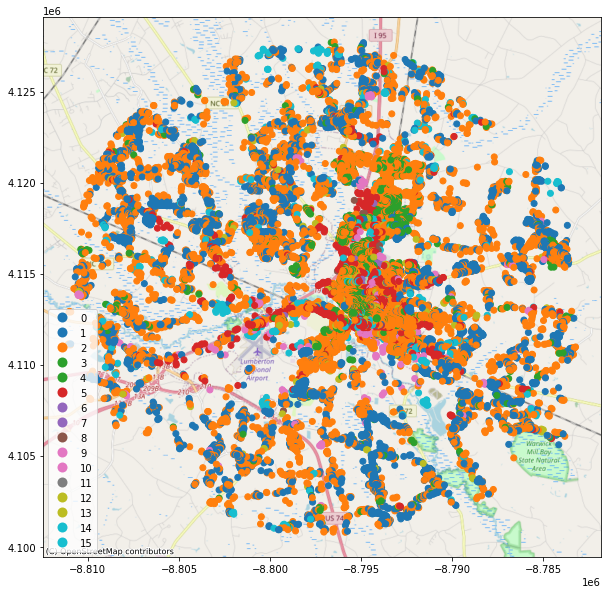

In [15]:
map = viz.plot_gdf_map(bldg_inv_gdf,column='archetype',category=True)
map

In [271]:
bldg_inv_gdf.columns

Index(['guid', 'strctid', 'ffe_elev', 'archetype', 'parid', 'struct_typ',
       'no_stories', 'a_stories', 'b_stories', 'bsmt_type', 'sq_foot',
       'gsq_foot', 'occ_type', 'occ_detail', 'major_occ', 'broad_occ',
       'repl_cst', 'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val',
       'efacility', 'dwell_unit', 'str_typ2', 'occ_typ2', 'appr_bldg',
       'appr_land', 'appr_tot', 'year_built', 'lhsm_elev', 'g_elev',
       'geometry'],
      dtype='object')

## Known issue with archetypes
For the new building inventory (62ab7dcbf328861e25ffea9e) - looks like archetypes for residential and warehouses are not correctly set. Get a weird fan shaped patten for the archetypes.

Contacted Omar Nofal to get his advice.

Using old building inventory to work with new housing unit allocation code.

In [16]:
''' # Use code to check building inventory by archetype
for archetype in range(1,16):
    #print(archetype)
    bldg_inv_gdf_archetype = bldg_inv_gdf[bldg_inv_gdf['archetype'].isin([archetype])]
    # Print number of buildings in each archetype
    #print(bldg_inv_gdf_archetype.shape[0])
    maps[archetype] = viz.plot_gdf_map(bldg_inv_gdf_archetype,column='archetype',category=True)
'''

" # Use code to check building inventory by archetype\nfor archetype in range(1,16):\n    #print(archetype)\n    bldg_inv_gdf_archetype = bldg_inv_gdf[bldg_inv_gdf['archetype'].isin([archetype])]\n    # Print number of buildings in each archetype\n    #print(bldg_inv_gdf_archetype.shape[0])\n    maps[archetype] = viz.plot_gdf_map(bldg_inv_gdf_archetype,column='archetype',category=True)\n"

## Read in Housing Unit Inventory

For more information see:

Rosenheim, Nathanael, Roberto Guidotti, Paolo Gardoni & Walter Gillis Peacock. (2019). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure. doi.org/10.1080/23789689.2019.1681821

Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. https://doi.org/10.17603/ds2-jwf6-s535.

In [17]:
# Housing Unit inventory
housing_unit_inv_id = "6262ef3204ce841cbeb30993"
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\6262ef3204ce841cbeb30993\hui_v2-0-0_Lumberton_NC_2010_rs1000\hui_v2-0-0_Lumberton_NC_2010_rs1000.csv


In [18]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")
housing_unit_inv_df.head()

,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,family,vacancy,gqtype,incomegroup,hhinc,randincome,poverty
0,B371559601011003H001,371559601011003,371559601011,37155960101,37155,1,1.0,1.0,0.0,0.0,0,0,1,1,9651.0,1.0
1,B371559601011005H001,371559601011005,371559601011,37155960101,37155,1,1.0,1.0,0.0,0.0,0,0,3,2,19695.0,0.0
2,B371559601011006H001,371559601011006,371559601011,37155960101,37155,1,1.0,1.0,0.0,0.0,0,0,1,1,6215.0,1.0
3,B371559601011006H002,371559601011006,371559601011,37155960101,37155,1,1.0,1.0,0.0,0.0,0,0,2,1,13776.0,0.0
4,B371559601011007H006,371559601011007,371559601011,37155960101,37155,1,2.0,1.0,0.0,0.0,0,0,5,3,27398.0,0.0


In [19]:
housing_unit_inv_df['huid'].describe()

count                    52801
unique                   52801
top       B371559601011003H001
freq                         1
Name: huid, dtype: object

## Read in Address Point Inventory
The address point inventory is an intermediate file based on the building inventory. The address point inventory acts as the bridge between the building inventory and the housing unit inventory.

In [20]:
# Address Point inventory
addpt_inv_id = "60aac382088dfa3b65030b16"
# load housing unit inventory as pandas dataframe
addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
filename = addpt_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\60aac382088dfa3b65030b16\IN-CORE_2fv1_Lumberton_Inventories_addresspointinventory\IN-CORE_2fv1_Lumberton_Inventories_addresspointinventory.csv


In [21]:
addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df.head()

,addrptid,guid,strctid,blockid,blockidstr,plcname10,plcgeoid10,countyfp10,huestimate,residential,bldgobs,flag_ap,x,y
0,ST2d32aeff-7b75-47e6-b7a5-4f4adca4b021AP000000,2d32aeff-7b75-47e6-b7a5-4f4adca4b021,ST2d32aeff-7b75-47e6-b7a5-4f4adca4b021,371559613011113,CB371559613011113,Lumberton,3739700.0,155,0.0,0,1,0,-78.99634,34.65436
1,ST400586f1-a265-4454-ba08-30eda28b974cAP000000,400586f1-a265-4454-ba08-30eda28b974c,ST400586f1-a265-4454-ba08-30eda28b974c,371559613011113,CB371559613011113,Lumberton,3739700.0,155,6.0,1,1,0,-78.99712,34.65410
2,ST400586f1-a265-4454-ba08-30eda28b974cAP000001,400586f1-a265-4454-ba08-30eda28b974c,ST400586f1-a265-4454-ba08-30eda28b974c,371559613011113,CB371559613011113,Lumberton,3739700.0,155,6.0,1,0,0,-78.99712,34.65410
3,ST400586f1-a265-4454-ba08-30eda28b974cAP000002,400586f1-a265-4454-ba08-30eda28b974c,ST400586f1-a265-4454-ba08-30eda28b974c,371559613011113,CB371559613011113,Lumberton,3739700.0,155,6.0,1,0,0,-78.99712,34.65410
4,ST400586f1-a265-4454-ba08-30eda28b974cAP000003,400586f1-a265-4454-ba08-30eda28b974c,ST400586f1-a265-4454-ba08-30eda28b974c,371559613011113,CB371559613011113,Lumberton,3739700.0,155,6.0,1,0,0,-78.99712,34.65410


## Set Up and Run Housing Unit Allocation v1
The building and housing unit inventories have already by loaded. The address point inventory is needed to link the population with the structures.

In [22]:
from pyincore.analyses.housingunitallocation import HousingUnitAllocation

# Create housing allocation 
hua = HousingUnitAllocation(client)

# Load input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv_id)
hua.load_remote_input_dataset("address_point_inventory", addpt_inv_id)
hua.load_remote_input_dataset("buildings", bldg_inv_id)

# Specify the result name
result_name = "Lumberton_HUA"

seed = 1238
iterations = 1

# Set analysis parameters
hua.set_parameter("result_name", result_name)
hua.set_parameter("seed", seed)
hua.set_parameter("iterations", iterations)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [23]:
# Run Housing unit allocation analysis
hua.run_analysis()

True

## Explore results from Housing Unit Allocation

In [313]:
# Retrieve result dataset
hua_result = hua.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
huav1_df = hua_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
huav1_df[['guid','numprec','incomegroup','geometry']].head()

,guid,numprec,incomegroup,geometry
0,NaN,2.0,11.0,NaN
1,NaN,1.0,1.0,NaN
2,NaN,3.0,10.0,NaN
3,NaN,2.0,9.0,NaN
4,NaN,1.0,3.0,NaN


In [314]:
huav1_df[['guid','huid','addrptid']].astype(str).describe().T

,count,unique,top,freq
guid,61505,20092,nan,33135
huid,61505,52802,nan,8704
addrptid,61505,61505,CB0000000000000000000371559601011002.0AP000000,1


In [26]:
# keep observations where the housing unit characteristics have been allocated to a structure.
#hua_df = hua_df.loc[hua_df['aphumerge'] == 'both']

In [27]:
#hua_df[['guid','huid','addrptid']].astype(str).describe().T

## How many GUIDs do not have HUIDs by Archetype?
This will be a good test for version 2 of the HUA.

In [315]:
huav1_df[['guid','addrptid','huid','archetype']].groupby('archetype').count()

,guid,addrptid,huid
archetype,,,
0.0,25,25,0
1.0,8426,8426,6166
2.0,14937,14937,11303
3.0,368,368,269
4.0,2501,2501,1887
5.0,1076,1076,22
6.0,9,9,0
7.0,10,10,0
8.0,15,15,1


In [316]:
# Condition 1  GUID is not missing
condition1 = (~huav1_df['guid'].isna())
# Condition 2 HUID is missing
condition2 = (huav1_df['huid'].isna())
check_df = huav1_df.loc[condition1 & condition2].copy()
check_df[['guid','huid','addrptid']].astype(str).describe().T

,count,unique,top,freq
guid,8704,7370,ef3e352d-6985-412f-8a14-bdd66f994696,10
huid,8704,1,nan,8704
addrptid,8704,8704,STdb8ef0d0-4f85-4a36-9d78-bc87e3b7dcfeAP000000,1


In [317]:
huav1_check_df = check_df[['guid','archetype']].groupby('archetype').count()
# reset index
huav1_check_df = huav1_check_df.reset_index()
# rename column guid to 'HUA v1 Missing HUID'
huav1_check_df = huav1_check_df.rename(columns={'guid':'HUA v1 Missing HUID'})
huav1_check_df

,archetype,HUA v1 Missing HUID
0,0.0,25
1,1.0,2260
2,2.0,3634
3,3.0,99
4,4.0,614
5,5.0,1054
6,6.0,9
7,7.0,10
8,8.0,14
9,9.0,150


Second version of Housing Unit ALlocation should reduce the number of observations in archetypes 1, 2, 3, and 4 that have a GUID but no HUID.

## Fix issue with HUA - Attempt 1 - Housing Unit Counter
Idea - add a housing unit counter to each addresspoint within a structure. 

The housing unit counter will be a common variable between the address point inventory and the housing unit inventory. 

In the address point inventory, the housing unit counter will be the count of the address points within the structure.

In the housing unit inventory, the housing unit counter will just be 1, 2 ,or 3.

The idea is that in the first random merge round housing units with a housing unit counter of 1 will be assigned to the first address point in the structure. This should have the effect of assigning one housing unit per structure before the second round of random merging.

After 3 rounds of attempting the merge with the housing unit counter the merge will run without the housing unit counter.

## Step 3: Housing Unit Allocation v2

### Setup notebook environment to access Cloned Github Package
This notebook uses functions that are in development. The current version of the package is available at:

https://github.com/npr99/intersect-community-data

Nathanael Rosenheim. (2022). npr99/intersect-community-data. Zenodo. https://doi.org/10.5281/zenodo.6476122

A permanent copy of the package and example datasets are available in the DesignSafe-CI repository:

Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

In [31]:
#To replicate this notebook Clone the Github Package to a folder that is a sibling of this notebook.
# To access the sibling package you will need to append the parent directory ('..') to the system path list.
# append the path of the directory that includes the github repository.
# This step is not required when the package is in a folder below the notebook file.
github_code_path  = ""
sys.path.append(github_code_path)

In [32]:
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

In [139]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_05a_hua_functions \
    import hua_workflow_functions
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_06c_Codebook import *
from pyncoda.ncoda_04a_Figures import *

from pyncoda.CommunitySourceData.api_census_gov.acg_00e_incore_huiv2 \
    import incore_v2_DataStructure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Example of data dictionary for one community with one county
communities = {'Lumberton_NC' : {
                    'community_name' : 'Lumberton, NC',
                    'counties' : { 
                        1 : {'FIPS Code' : '37155', 'Name' : 'Robeson County, NC'}}}}

In [35]:
version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"
# Make directory to save output
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Set random seed for reproducibility
seed = 1000
basevintage = 2010


In [210]:
for community in communities.keys():
    # Create empty container to store outputs for in-core
    # Will use these to combine multiple counties
    hua_incore_county_df = {}
    print("Setting up Housing Unit Inventory for",communities[community]['community_name'])
    for county in communities[community]['counties'].keys():
        state_county = communities[community]['counties'][county]['FIPS Code']
        state_county_name  = communities[community]['counties'][county]['Name']
        print(state_county_name,': county FIPS Code',state_county)
    
        outputfolders = directory_design(state_county_name = state_county_name,
                                            outputfolder = outputfolder)
                                            
        generate_df = hua_workflow_functions(
            hui_df = housing_unit_inv_df,
            addpt_df=addpt_inv_df,
            bldg_df=bldg_inv_gdf,
            state_county = state_county,
            state_county_name= state_county_name,
            seed = seed,
            version = version,
            version_text = version_text,
            basevintage = basevintage,
            outputfolder = outputfolder,
            outputfolders = outputfolders)

        # Generate base housing unit inventory
        base_hua_df = generate_df.run_hua_workflow(savelog=False)

        #hua_df = base_hua_df['primary']

    '''
    #Save results for community name
    output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}'
    csv_filepath = outputfolders['top']+"/"+output_filename+'.csv'
    savefile = sys.path[0]+"/"+csv_filepath
    hua_df.to_csv(savefile, index=False)

    # Save second set of files in common directory
    common_directory = outputfolders['top']+"/../"+output_filename
    hua_df.to_csv(common_directory+'.csv', index=False)
    '''


Setting up Housing Unit Inventory for Lumberton, NC
Robeson County, NC : county FIPS Code 37155

***************************************
    Run Housing Unit Allocation for Robeson County, NC
***************************************


***************************************
    Merge housing unit and address point data with first 3 counters.
***************************************

Round 1

***************************************
***************************************

Performing random merge at geography level: Block

***************************************
***************************************


***************************************
***************************************

Attempt to merge hui on all common group vars.

***************************************
***************************************

Running random merge by ['Block2010', 'huicounter1', 'ownershp1']

***************************************
    Setting up  primary data with primary key and flags
********************

In [211]:
base_hua_df['primary'].head()

,huid,Block2010,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid,strctid_flagsetrm,strctid_Block2010_flagsetrm,addrptid,guid,huestimate,huicounter_addpt,plcname10,x,y
0,B371559601011003H001,371559601011003,371559601011003,371559601011,37155960101,37155,1,1.0,1.0,0.0,...,CB0000000000000000000371559601011003.0,2.0,2.0,CB0000000000000000000371559601011003.0AP000000,NaN,NaN,1.0,Unincorporated Robeson County,-78.95882,34.89573
1,B371559601011005H001,371559601011005,371559601011005,371559601011,37155960101,37155,1,1.0,1.0,0.0,...,CB0000000000000000000371559601011005.0,2.0,2.0,CB0000000000000000000371559601011005.0AP000000,NaN,NaN,1.0,Unincorporated Robeson County,-78.96133,34.88307
2,B371559601011006H001,371559601011006,371559601011006,371559601011,37155960101,37155,1,1.0,1.0,0.0,...,CB0000000000000000000371559601011006.0,2.0,2.0,CB0000000000000000000371559601011006.0AP000000,NaN,NaN,1.0,Unincorporated Robeson County,-78.96053,34.88246
3,B371559601011006H002,371559601011006,371559601011006,371559601011,37155960101,37155,1,1.0,1.0,0.0,...,CB0000000000000000000371559601011006.0,2.0,2.0,CB0000000000000000000371559601011006.0AP000001,NaN,NaN,2.0,Unincorporated Robeson County,-78.96053,34.88246
4,B371559601011007H006,371559601011007,371559601011007,371559601011,37155960101,37155,1,2.0,1.0,0.0,...,CB0000000000000000000371559601011007.0,2.0,2.0,CB0000000000000000000371559601011007.0AP000005,NaN,NaN,6.0,Unincorporated Robeson County,-78.95745,34.88157


In [212]:
base_hua_df['secondary'].head()

,addptid,Block2010,blockid,blockidstr,plcgeoid10,countyfp10,residential,bldgobs,flag_ap,huicounter1,...,strctid,strctid_flagsetrm,strctid_Block2010_flagsetrm,addrptid,guid,huestimate,huicounter_addpt,plcname10,x,y
0,371559613011113001,371559613011113,371559613011113,CB371559613011113,3739700.0,155,0,1,0,1,...,ST2d32aeff-7b75-47e6-b7a5-4f4adca4b021,2.0,2.0,ST2d32aeff-7b75-47e6-b7a5-4f4adca4b021AP000000,2d32aeff-7b75-47e6-b7a5-4f4adca4b021,0.0,1.0,Lumberton,-78.99634,34.65436
1,371559613011113002,371559613011113,371559613011113,CB371559613011113,3739700.0,155,1,1,0,1,...,ST400586f1-a265-4454-ba08-30eda28b974c,1.0,1.0,ST400586f1-a265-4454-ba08-30eda28b974cAP000000,400586f1-a265-4454-ba08-30eda28b974c,6.0,1.0,Lumberton,-78.99712,34.65410
2,371559613011113003,371559613011113,371559613011113,CB371559613011113,3739700.0,155,1,0,0,2,...,ST400586f1-a265-4454-ba08-30eda28b974c,1.0,1.0,ST400586f1-a265-4454-ba08-30eda28b974cAP000001,400586f1-a265-4454-ba08-30eda28b974c,6.0,2.0,Lumberton,-78.99712,34.65410
3,371559613011113004,371559613011113,371559613011113,CB371559613011113,3739700.0,155,1,0,0,3,...,ST400586f1-a265-4454-ba08-30eda28b974c,1.0,1.0,ST400586f1-a265-4454-ba08-30eda28b974cAP000002,400586f1-a265-4454-ba08-30eda28b974c,6.0,3.0,Lumberton,-78.99712,34.65410
4,371559613011113005,371559613011113,371559613011113,CB371559613011113,3739700.0,155,1,0,0,4,...,ST400586f1-a265-4454-ba08-30eda28b974c,2.0,2.0,ST400586f1-a265-4454-ba08-30eda28b974cAP000003,400586f1-a265-4454-ba08-30eda28b974c,6.0,4.0,Lumberton,-78.99712,34.65410


In [243]:
updated_ownership_df = base_hua_df['primary'][['ownershp','strctid']].\
    groupby('strctid').mean()
updated_ownership_df.reset_index(inplace=True)
# rename ownership column to predictownershp
updated_ownership_df.rename(columns={'ownershp':'predictownershp'},
    inplace=True)

condition1 = (updated_ownership_df['predictownershp'] != 1)
condition2 = (updated_ownership_df['predictownershp'] != 2)
updated_ownership_df.loc[condition1 & condition2]

,strctid,predictownershp
1,CB0000000000000000000371559601011003.0,1.666667
2,CB0000000000000000000371559601011005.0,1.333333
3,CB0000000000000000000371559601011006.0,1.850000
4,CB0000000000000000000371559601011007.0,1.790698
6,CB0000000000000000000371559601011009.0,1.230769
...,...,...
17782,STf99f0b97-db80-4f71-be99-f2985eb8d9e2,1.750000
17857,STfaf0e986-b797-48ef-869a-e6c35228109f,1.250000
17903,STfba1986e-b7d1-4d8c-a947-cf27e7bf0b71,1.500000
17924,STfbf6d763-9edc-43e7-8916-e7bcb55e7e8b,1.500000


In [245]:
check_id = 'STf99f0b97-db80-4f71-be99-f2985eb8d9e2'
base_hua_df['primary'].loc[base_hua_df['primary']['strctid'] == check_id]

,huid,Block2010,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid,strctid_flagsetrm,strctid_Block2010_flagsetrm,addrptid,guid,huestimate,huicounter_addpt,plcname10,x,y
2720,B371559613022018H001,371559613022018,371559613022018,371559613022,37155961302,37155,1,1.0,1.0,0.0,...,STf99f0b97-db80-4f71-be99-f2985eb8d9e2,2.0,2.0,STf99f0b97-db80-4f71-be99-f2985eb8d9e2AP000003,f99f0b97-db80-4f71-be99-f2985eb8d9e2,4.0,4.0,Lumberton,-78.99203,34.64309
2727,B371559613022018H012,371559613022018,371559613022018,371559613022,37155961302,37155,1,2.0,1.0,0.0,...,STf99f0b97-db80-4f71-be99-f2985eb8d9e2,1.0,1.0,STf99f0b97-db80-4f71-be99-f2985eb8d9e2AP000000,f99f0b97-db80-4f71-be99-f2985eb8d9e2,4.0,1.0,Lumberton,-78.99203,34.64309
23730,B371559613022018H020,371559613022018,371559613022018,371559613022,37155961302,37155,1,2.0,3.0,0.0,...,STf99f0b97-db80-4f71-be99-f2985eb8d9e2,1.0,1.0,STf99f0b97-db80-4f71-be99-f2985eb8d9e2AP000002,f99f0b97-db80-4f71-be99-f2985eb8d9e2,4.0,3.0,Lumberton,-78.99203,34.64309
50007,B371559613022018H018,371559613022018,371559613022018,371559613022,37155961302,37155,3,2.0,2.0,0.0,...,STf99f0b97-db80-4f71-be99-f2985eb8d9e2,1.0,1.0,STf99f0b97-db80-4f71-be99-f2985eb8d9e2AP000001,f99f0b97-db80-4f71-be99-f2985eb8d9e2,4.0,2.0,Lumberton,-78.99203,34.64309


In [215]:
check_df = base_hua_df['primary'].\
    loc[base_hua_df['primary']['huicounter_addpt'] == 1].copy()
check_df[['huid','strctid','huicounter_addpt','ownershp','huestimate']].\
    groupby(['huestimate','huicounter_addpt','ownershp']).count()

huid  strctid
huestimate huicounter_addpt ownershp               
0.0        1.0              1.0         31       31
                            2.0         11       11
1.0        1.0              1.0       6153     6153
                            2.0       2790     2790
2.0        1.0              1.0       3593     3593
                            2.0       2198     2198
3.0        1.0              1.0         34       34
                            2.0        412      412
4.0        1.0              1.0         13       13
                            2.0         87       87
5.0        1.0              1.0          5        5
                            2.0         51       51
6.0        1.0              2.0         33       33
7.0        1.0              1.0          3        3
                            2.0         21       21
8.0        1.0              1.0          1        1
                            2.0         15       15
9.0        1.0              2.0          7        7
10.0       1.0              2.0          3        3
11.0       1.0              2.0          2        2
12.0       1.0              2.0          1        1
14.0       1.0              2.0          1        1
15.0       1.0              2.0          1        1
16.0       1.0              2.0          2        2
17.0       1.0              2.0          1        1
19.0       1.0              2.0          2        2
20.0       1.0              2.0          2        2
21.0       1.0              2.0          1        1
24.0       1.0              2.0          1        1
25.0       1.0              2.0          1        1
38.0       1.0              2.0          1        1
41.0       1.0              2.0          1        1

In [216]:
# Merge building inventory with housing unit allocation results
huav2_df = pd.merge(base_hua_df['primary'], bldg_inv_gdf, on='guid', how='outer')

In [229]:
# Condition 1  GUID is not missing
condition1 = (~huav2_df['guid'].isna())
# Condition 2 HUID is missing
condition2 = (huav2_df['huid'].isna())
check_df = huav2_df.loc[condition1 & condition2].copy()
check_df[['guid','huid','addrptid']].astype(str).describe().T

,count,unique,top,freq
guid,4599,4599,6e6e52a0-86b3-455a-bf6b-e57fbf10dff4,1
huid,4599,1,nan,4599
addrptid,4599,1,nan,4599


In [231]:
huav2_check_df = check_df[['guid','archetype']].groupby('archetype').count()
# reset index
huav2_check_df = huav2_check_df.reset_index()
# rename column guid to 'HUA v1 Missing HUID'
huav2_check_df = huav2_check_df.rename(columns={'guid':'HUA v2 Missing HUID'})
huav2_check_df

,archetype,HUA v2 Missing HUID
0,0.0,24
1,1.0,986
2,2.0,1421
3,3.0,35
4,4.0,118
5,5.0,1025
6,6.0,9
7,7.0,9
8,8.0,13
9,9.0,146


In [248]:
# merge huav2_check_df huav1_check_df
check_versions = pd.merge(left = huav1_check_df,
                          right = huav2_check_df, 
                          on='archetype', how='outer')

# add total row
check_versions = check_versions.append(check_versions.sum(numeric_only=True), ignore_index=True)

# Generate percent improvement
check_versions['reduced error'] = \
    check_versions['HUA v1 Missing HUID']-check_versions['HUA v2 Missing HUID']
check_versions['percent improvement'] = \
    round((check_versions['reduced error'] / \
    check_versions['HUA v1 Missing HUID']) * 100, 2)
check_versions

C:\Users\nathanael99\AppData\Local\Temp\ipykernel_13116\2502571932.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  check_versions = check_versions.append(check_versions.sum(numeric_only=True), ignore_index=True)


,archetype,HUA v1 Missing HUID,HUA v2 Missing HUID,reduced error,percent improvement
0,0.0,25.0,24.0,1.0,4.00
1,1.0,2260.0,986.0,1274.0,56.37
2,2.0,3634.0,1421.0,2213.0,60.90
3,3.0,99.0,35.0,64.0,64.65
4,4.0,614.0,118.0,496.0,80.78
5,5.0,1054.0,1025.0,29.0,2.75
6,6.0,9.0,9.0,0.0,0.00
7,7.0,10.0,9.0,1.0,10.00
8,8.0,14.0,13.0,1.0,7.14
9,9.0,150.0,146.0,4.0,2.67


In [ ]:
# List of all communities available in IN-CORE
communities = {'Lumberton_NC' : {
                    'community_name' : 'Lumberton, NC',
                    'counties' : { 
                        1 : {'FIPS Code' : '37155', 'Name' : 'Robeson County, NC'}}},                   
                'Shelby_TN' : {
                    'community_name' : 'Memphis, TN',
                    'counties' : { 
                        1 : {'FIPS Code' : '47157', 'Name' : 'Shelby County, TN'}}},
                'Joplin_MO' : {
                    'community_name' : 'Joplin, MO',
                    'counties' : { 
                        1 : {'FIPS Code' : '29097', 'Name' : 'Jasper County, MO'},
                        2 : {'FIPS Code' : '29145', 'Name' : 'Newton County, MO'}}},
                'Seaside_OR' : {
                    'community_name' : 'Seaside, OR',
                    'counties' : { 
                        1 : {'FIPS Code' : '41007', 'Name' : 'Clatsop County, OR'}}},                   
                'Galveston_TX' : {
                    'community_name' : 'Galveston, TX',
                    'counties' : { 
                        1 : {'FIPS Code' : '48167', 'Name' : 'Galveston County, TX'}}},
                'Mobile_AL' : {
                    'community_name' : 'Mobile, AL',
                    'counties' : { 
                        1 : {'FIPS Code' : '01097', 'Name' : 'Mobile County, AL'}}}                    
                }

In [306]:
from pyncoda.ncoda_04b_foliummaps import *

In [251]:
huav2_df['Block2010'].head()

0    371559601011003
1    371559601011005
2    371559601011006
3    371559601011006
4    371559601011007
Name: Block2010, dtype: object

In [258]:
# Condition 1  GUID is not missing
condition1 = (huav2_df['Block2010'] == '371559613021014')
df1 = huav2_df.loc[condition1].copy()
df1[['huid','guid','addrptid']].astype(str).describe().T

,count,unique,top,freq
huid,17,17,B371559613021014H001,1
guid,17,15,54ff686f-ed59-4644-9807-f35fd9ab1b4b,2
addrptid,17,17,STc621a70a-9f73-42fb-b3e4-30424081fa91AP000000,1


In [286]:
# Merge building inventory with housing unit allocation results
gdf1 = pd.merge(left = bldg_inv_gdf[['guid','strctid','geometry','archetype']],
                    right = df1[['huid','guid','addrptid','x','y',
                    'Block2010', 'blockid', 'bgid', 'tractid', 'FIPScounty', 'numprec',
                    'ownershp', 'race', 'hispan', 'family', 'vacancy', 'gqtype',
                    'incomegroup', 'hhinc', 'randincome', 'poverty']],
                    on='guid', how='right')

In [287]:
gdf1.columns

Index(['guid', 'strctid', 'geometry', 'archetype', 'huid', 'addrptid', 'x',
       'y', 'Block2010', 'blockid', 'bgid', 'tractid', 'FIPScounty', 'numprec',
       'ownershp', 'race', 'hispan', 'family', 'vacancy', 'gqtype',
       'incomegroup', 'hhinc', 'randincome', 'poverty'],
      dtype='object')

In [282]:
gdf1[['huid','guid','addrptid']].astype(str).describe().T

,count,unique,top,freq
huid,17,17,B371559613021014H001,1
guid,17,15,54ff686f-ed59-4644-9807-f35fd9ab1b4b,2
addrptid,17,17,STc621a70a-9f73-42fb-b3e4-30424081fa91AP000000,1


In [295]:
import geopandas as gpd
# count by geometry
guid_count_df = gdf1[['huid','x','y']].groupby(['x','y']).count()
# reset index
guid_count_df = guid_count_df.reset_index()
# convert points to gdf
guid_count_gdf = gpd.GeoDataFrame(
    guid_count_df, geometry=gpd.points_from_xy(guid_count_df.x, guid_count_df.y))

In [336]:

folium_marker_layer_map(gdf = guid_count_gdf,
                        gdfvar="huid",
                        layername = "HUID count v2",
                        k = 3)

In [382]:
def count_huid_by_building(hua_df, 
                            blocknum = '',
                            groupby_vars = ['x','y']):
    """
    Select housing units in a block
    """

    # Check if Block2010 is missing
    if 'Block2010' not in hua_df.columns:
        # Add block id 2010 as string
        # zero pad block id to 15 digits
        huav1_df['Block2010'] = huav1_df['blockid'].apply(lambda x : str(int(x)).zfill(15))

    # check if block number is set
    if blocknum != '':
        condition1 = (hua_df['Block2010'] == blocknum)
        block_df = hua_df.loc[condition1].copy()
    else:
        block_df = hua_df.copy()

    # Merge building inventory with housing unit allocation results
    bldg_hua_df = pd.merge(left = bldg_inv_gdf[['guid','strctid','geometry','archetype']],
                        right = block_df[['huid','guid','addrptid','x','y',
                        'Block2010', 'blockid', 'bgid', 'tractid', 'FIPScounty', 'numprec',
                        'ownershp', 'race', 'hispan', 'family', 'vacancy', 'gqtype',
                        'incomegroup', 'hhinc', 'randincome', 'poverty']],
                        on='guid', how='right')

    # count by geometry
    huid_count_df = bldg_hua_df[['huid']+groupby_vars].groupby(groupby_vars).count()
    # reset index
    huid_count_df = huid_count_df.reset_index()

    return huid_count_df

def map_selected_block(hua_df, blocknum):

    # count huid by building
    huid_count_df = count_huid_by_building(hua_df, blocknum)

    # convert points to gdf
    huid_count_gdf = gpd.GeoDataFrame(
        huid_count_df, geometry=gpd.points_from_xy(huid_count_df.x, huid_count_df.y))

    """
    # convert dataframe to geodataframe using geometry
    from shapely.wkt import loads
    huid_count_gdf = gpd.GeoDataFrame(huid_count_df).copy(deep=True)
    huid_count_gdf['geometry'] = huid_count_gdf['geometry'].apply(lambda x : loads(x))
    """

    # Map housing units in block
    map = folium_marker_layer_map(gdf = huid_count_gdf,
                            gdfvar="huid",
                            layername = "HUID count",
                            color_levels = 3)
    return map

In [383]:
map_selected_block(hua_df = huav2_df, blocknum = '371559613021014')

In [384]:
map_selected_block(hua_df = huav1_df, blocknum = '371559613021014')

"\n# convert dataframe to geodataframe using geometry\nfrom shapely.wkt import loads\nhua_blockelect_gdf = gpd.GeoDataFrame(hua_blockelect_df).copy(deep=True)\nhua_blockelect_gdf['geometry'] = hua_blockelect_gdf['geometry'].apply(lambda x : loads(x))\n"

In [381]:
huidv1_count_gdf = count_huid_by_building(hua_df = huav1_df, 
                            blocknum = '',
                            groupby_vars=['Block2010'])
huidv1_count_gdf.head()

AttributeError: 'DataFrame' object has no attribute 'x'

In [376]:
huidv2_count_gdf = count_huid_by_building(hua_df = huav2_df, blocknum = '')
huidv2_count_gdf.head()

,x,y,huid,geometry
0,-79.45516,34.63530,1,POINT (-79.45516 34.63530)
1,-79.44926,34.63525,1,POINT (-79.44926 34.63525)
2,-79.44305,34.64161,11,POINT (-79.44305 34.64161)
3,-79.43873,34.64698,5,POINT (-79.43873 34.64698)
4,-79.43481,34.62648,2,POINT (-79.43481 34.62648)
